### Redes Neuronales Avanzadas con Keras

Situación: Eres científico de datos en una empresa de telecomunicaciones. Quieres predecir la tasa de abandono de clientes (churn) con una red neuronal profunda. El dataset tiene 10 características demográficas y de uso.

#### 1. Importaciones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


### 2. Generar Datos Sintéticos Realistas.

In [2]:
# Crear dataset de 1000 clientes
np.random.seed(42)
n = 1000

# Características
edad = np.random.randint(18, 80, n)
meses_contrato = np.random.randint(1, 72, n)
gastos_mensual = np.random.uniform(20, 200, n)
llamadas_atencion = np.random.randint(0, 10, n)

# Crear variable target (churn) con relación no lineal.
churn_prob = 1 / (1 + np.exp(-(0.05 * edad - 0.1 * meses_contrato + 0.02 * gastos_mensual - 0.5 * llamadas_atencion)))
churn = (churn_prob > 0.5).astype(int)

# DataFrame completo
df_churn = pd.DataFrame({
    'edad': edad,
    'meses_contrato': meses_contrato,
    'gastos_mensual': gastos_mensual,
    'llamadas_atencion': llamadas_atencion,
    'churn': churn
})

print("Distribución de churn:")
print(df_churn['churn'].value_counts())
print(f"\nPrimeras 5 filas:")
df_churn.head()

Distribución de churn:
churn
0    643
1    357
Name: count, dtype: int64

Primeras 5 filas:


,edad,meses_contrato,gastos_mensual,llamadas_atencion,churn
0,56,11,100.346356,7,1
1,69,26,175.558912,5,1
2,46,63,120.465245,0,0
3,32,59,117.183051,3,0
4,60,27,26.153798,0,1


#### 3. Preprocesamiento y División de Datos.

In [3]:
# Separar características y target
X = df_churn.drop('churn', axis = 1)
y = df_churn['churn']

# Estandarizar caracteristicas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42, stratify = y)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

Forma de X_train: (800, 4)
Forma de X_test: (200, 4)


#### 4. Construir Red Neuronal Avanzada.

In [4]:
# Crear modelo secuencial
model = Sequential()

# Capa de entrada y primera capa oculta
model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu', name = 'capa_entrada'))
model.add(Dropout(0.3)) # Dropout para regularización

# Segunda capa oculta
model.add(Dense(32, activation = 'relu', name = 'capa_oculta_1'))
model.add(Dropout(0.3))

# Tercera capa oculta
model.add(Dense(16, activation = 'relu', name = 'capa_oculta2'))

# Capa de salida (clasificación binaria)
model.add(Dense(1, activation = 'sigmoid', name = 'capa_salida'))

# Compilar modelo
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', 'precision', 'recall']
)

# Resumen del modelo
model.summary()

c:\Users\PrancherC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  bias_constraint=None,


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_entrada (Dense)            │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_1 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta2 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

#### 5. Entrenamiento con Early Stopping

In [5]:
# Configurar early stopping
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    verbose = 1
)

# Entrenar modelo
history = model.fit(
    X_train, y_train,
    epochs = 100,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3938 - loss: 0.7355 - precision: 0.2737 - recall: 0.3949 - val_accuracy: 0.6812 - val_loss: 0.6657 - val_precision: 0.6176 - val_recall: 0.3559
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7108 - loss: 0.6333 - precision: 0.6103 - recall: 0.4350 - val_accuracy: 0.8313 - val_loss: 0.5618 - val_precision: 0.9444 - val_recall: 0.5763
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8524 - loss: 0.5184 - precision: 0.9142 - recall: 0.6355 - val_accuracy: 0.9187 - val_loss: 0.4082 - val_precision: 0.9423 - val_recall: 0.8305
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8827 - loss: 0.4030 - precision: 0.8822 - recall: 0.7897 - val_accuracy: 0.9563 - val_loss: 0.2627 - val_precision: 0.9643 - val_recall: 0.9153
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9098 - loss: 0.3031 - precision: 0.9106 - recall: 0.8234 - val_accuracy: 0.9688 - val_loss: 0.

#### 6. Evaluación y Visualización.

In [6]:
# Evaluar en test
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose = 0)
print(f'\nResultados en Test:')
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")


Resultados en Test:
Accuracy: 0.9950
Precision: 0.9861
Recall: 1.0000


<function matplotlib.pyplot.show(close=None, block=None)>

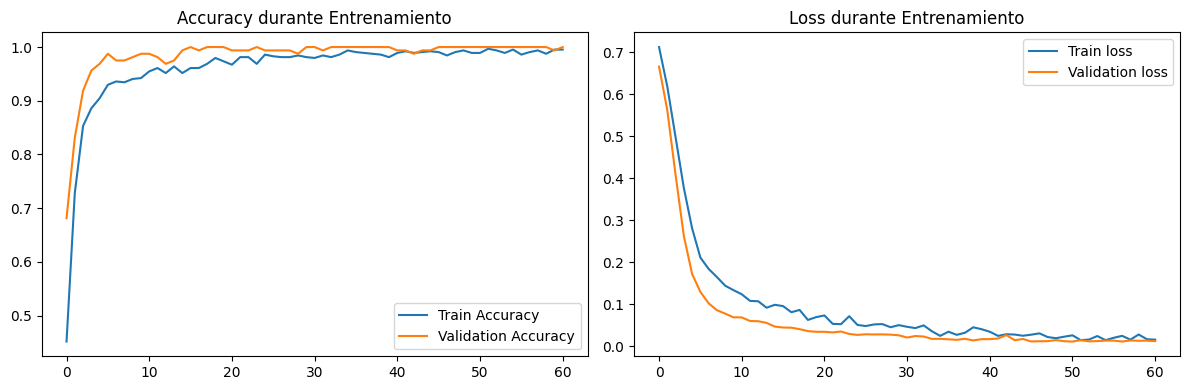

In [9]:
# Gráficas de entrenamiento
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy durante Entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Loss durante Entrenamiento')
plt.legend()

plt.tight_layout()
plt.show

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


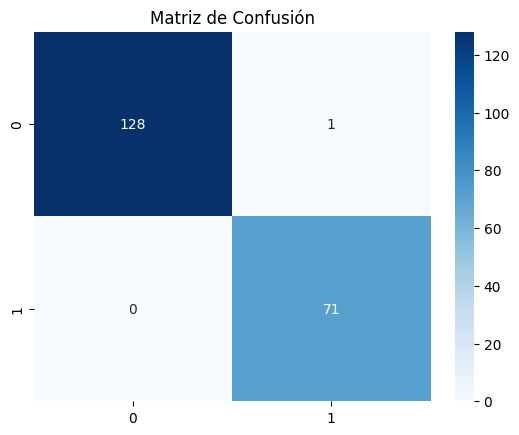

In [10]:
# Matriz de confusión
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Matriz de Confusión')

plt.show()

#### 7. Interpretación y Predicciones.

In [11]:
# Hacer predicciones para nuevos clientes
nuevos_clientes = np.array([[45, 24, 100, 2], [65, 3, 50, 8]]) # [edad, meses, gasto, llamadas]
nuevos_clientes_scaled = scaler.fit_transform(nuevos_clientes)

predicciones = model.predict(nuevos_clientes_scaled)
probabilidades = model.predict(nuevos_clientes_scaled)

print("\nPredicciones para nuevos clientes:")
for i, (cliente, prob) in enumerate(zip(nuevos_clientes, probabilidades)):
    print(f"Cliente {i+1}: Probabilidad de churn = {prob[0]:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Predicciones para nuevos clientes:
Cliente 1: Probabilidad de churn = 0.00%
Cliente 2: Probabilidad de churn = 0.28%
